## ROI detection on CRX for COVID 19.

Check original code on roi_detection_v2_original.ipynb


In [1]:
# Single Object Detection notebook - 1 ROI for the 2 lungs


# When I want to close any Google Colab project, before 
# I have to finish all the opened sessions 
# (go to Entorno de ejecucion > Gestionar sesiones)
# After finishing all the sesions I've to
# select None as execution environment 

# Uncomment the next lines only when loading a new execution environment (GPU/TPU)
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version  


# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False check if some other notebook is using the GPU, in that case close it and restart the execution of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [4]:
# Uncomment next line if "from fastai.vision.all import *" returns error
# !pip install fastai --upgrade 

from fastai.vision.all import *

from fastai.vision import *
# from fastai.metrics import accuracy
# from fastai.basic_data import *
# from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import cv2
from skimage.util import montage

## Getting and converting the data

In [5]:
# Get the path of the images of the dataset 

# Use next line on Google Colab
# path = '/content/drive/MyDrive/Universitat/21_22/TFG/Algoritme/Datasets/roi_detection_subset_originalRobert/'

# Use next line on VS Code
ds_path = 'Datasets/roi_detection_subset_originalRobert/train_val/'

In [6]:
# NOTE: Variables not used

batch_size = 16
img_size = 224


In [7]:
# Get an image path from the dataset that will be used as a test to detect lungs
imgPath = ds_path + 'valid/72101428196582307502088862225697086951_h22qux.png'

In [8]:
''' ORIGINAL CODE
def img2txt_name(f):
    "Get the path of the annotations .txt file associated to the image with filename 'f'"
    f = os.path.basename(f)
    return ds_path+f'{str(f)[:-4]}.txt'
'''

# NEW CODE

# Get the annotations associated to an image 
def img2txt_name(imgPath): # imgPath is a string that contains the path of an image
    return imgPath.replace('.png', '.txt')

Path of the annotations file: Datasets/roi_detection_subset_originalRobert/train_val/valid/72101428196582307502088862225697086951_h22qux.txt
Image size: (524, 524)


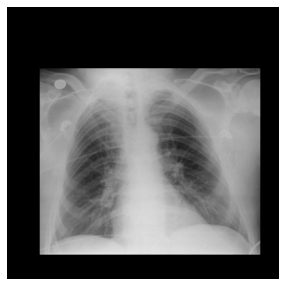

In [9]:
# Create the image associated to the filename stored previously
img = PILImage.create(imgPath)
img.show()
# Show the path of the annotations file associated to the image
print("Path of the annotations file:", img2txt_name(imgPath))
print("Image size:", img.size)

In [10]:
# Get the data of the annotations .txt file 

# ORIGINAL CODE
# ctr = np.genfromtxt(img2txt_name(Path(fname))); ctr

# NEW CODE
annotations = np.genfromtxt(img2txt_name(imgPath)); annotations


# annotations is an array that contains a list ([]) of the bounding box data created with LabelImg. The bbox encapsulates the two lungs of the image.
# The list has the following elements: 
# idClass, center_x, center_y, width and height); all the values exluding the idClass are relative to the size of the image

array([0.      , 0.537214, 0.583969, 0.730916, 0.568702])

In [11]:
def get_bbox(f):
    ''' Return a list with an array of the bounding box coordinates associated to the filename 'f' '''
    # ORIGINAL CODE:
    # img = PILImage.create(path+fname) # WRONG because fname is not related to parameter 'f', it's related to the fname of the example shown before 
    # ctr = np.genfromtxt(img2txt_name(Path(f)))
    # NEW CODE:
    img = PILImage.create(str(f))
    # Get the annotations of the bounding boxes of the lungs of the rx image with Path "f"
    fullAnnot = np.genfromtxt(img2txt_name(str(f)))

    # YOLO format x, y, width and height. x, y is the center of the rectangle.
    cx = int(fullAnnot[1]*img.size[0])
    cy = int(fullAnnot[2]*img.size[1])
    
    w = int(fullAnnot[3]*img.size[0])
    h = int(fullAnnot[4]*img.size[1])
    
 
    bbox= np.zeros(4)
    # ORIGINAL CODE (wrong order of coordinates, I know it because of the results of Data Augmentation)
    # careful! fastaiv2 change y coordinate first!
    #miny minx maxy maxX
    #bbox[0] = float(cy-h/2.0)#/img.size[1]#*img_size
    #bbox[1] = float(cx-w/2.0)#/img.size[0]#*img_size
    #bbox[2] = float(cy+h/2.0)#/img.size[1]#*img_size
    #bbox[3] = float(cx+w/2.0)#/img.size[0]#*img_size
    
    # Modified code (correct code)
    #minx miny maxX maxY # NOTE: Confirm if this is right order because the results of Data Augmentation aren't right
    bbox[0] = float(cx-w/2.0)#/img.size[0]#*img_size # NOTE: why there isn't done the absolute value? 
    bbox[1] = float(cy-h/2.0)#/img.size[1]#*img_size # NOTE: same question as above, bbox[0] & bbox[1] will be negative because w > cx & h > cy
    bbox[2] = float(cx+w/2.0)#/img.size[0]#*img_size
    bbox[3] = float(cy+h/2.0)#/img.size[1]#*img_size
  
    
#    print(tensor(bbox))
    classes = int(0);
#     aux = [[bbox],[classes]]
#    aux = [bbox,["0"]]
#     aux = [tensor(bbox),[classes]]
    aux = [bbox]
    return aux

def get_label(f):
    ''' Return a list with the label/idClass of the bounding box associated to the filename 'f' '''

    return ["0"]

#get_y = [lambda o: get_bbox(o.name), lambda o: get_label(o.name)] 
# get_y is used on the definition of DataBlock() object [Check 'Creating a dataset' section]
# get_y must collect the targets and in our case the targets are the bounding boxes and it's labels
# So, get_y is a 2D list where each inner list contains 2 elements: 1 -> a list of bounding boxes for all the images;
# 2 -> a list of labels of the bounding boxes of all the images
# No parameter is passed to get_bbox and get_label because it's not necessary
# the filename 'f' parameter will be passed by the DataBlock object automatically # NOTE: check if this is how it is?

In [12]:
print(img.size)

(524, 524)


In [13]:
# Get an array of the real coordinates (center_x, center_y, width, height) 
# of the bbox related to the filename 'fname'

# We say real coordinates because now the coordinates collected aren't 
# relative to the size of the image like on "ctr = np.genfromtxt(img2txt_name(Path(fname)))"

#get_bbox(fname)

In [14]:
# NOTE: what is a LabeledBbox()? 
# NOTE: what is a TensorBBox?

def get_labelBBox (bbox): return LabeledBBox(TensorBBox(bbox[0]),bbox[1])

In [15]:
#bbox = [get_bbox(fname), get_label(fname)]
#print(bbox)
# v1 bbox = ImageBBox.create(*img.size, bbox[0], labels = [0], classes=['lung'])

#v2 tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
# ctx = coco_img.show(figsize=(3,3), cmap='Greys')
# tbbox.show(ctx=ctx);

#tbbox = get_labelBBox(bbox)
# NOTE: Understand why the next warning is produced and try to solve it 

In [16]:
#print(tbbox)
#ctx = img.show(figsize=(3,3), cmap='Greys')
#tbbox.show(ctx=ctx);

## Creating a dataset

In [17]:
class NoLabelBBoxLabeler(Transform):
    """ Bounding box labeler with no label """
    def setups(self, x): noop
    def decode (self, x, **kwargs):
        self.bbox,self.lbls = None,None
        return self._call('decodes', x, **kwargs)

    def decodes(self, x:TensorBBox):
        self.bbox = x
        return self.bbox if self.lbls is None else LabeledBBox(self.bbox, self.lbls)

CustomBboxBlock = TransformBlock(type_tfms=TensorBBox.create, 
                             item_tfms=[PointScaler, NoLabelBBoxLabeler])   

In [18]:
# tfms = [*aug_transforms(size=(240,320),max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0), 
#                 Normalize.from_stats(*imagenet_stats)]
# tfms = [*aug_transforms(size=(240,320)),Normalize.from_stats(*imagenet_stats)]


tfms = [*aug_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2),Normalize.from_stats(*imagenet_stats)]

tfms = []
data = DataBlock(
    blocks=(ImageBlock, CustomBboxBlock),
    get_items=get_image_files,
    n_inp=1,
    get_y= get_bbox,
    splitter = FuncSplitter(lambda img: Path(img).parent.name == 'valid'), # split items by result of func (True for validation, False for training set). Images whose folder name is 'valid' are added to the validation set and the rest images are added to the training set.
    batch_tfms= [*aug_transforms(size=(120,160)), Normalize.from_stats(*imagenet_stats)] # NOTE: Què fa Normalize.from_stats
)

In [19]:
path_dl = Path(ds_path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#4) [Path('models'),Path('train'),Path('trained_roi_detetor_resnet_export.pkl'),Path('valid')]

c:\Users\marcp\AppData\Local\Programs\Python\Python37\lib\site-packages\fastai\torch_core.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


c:\Users\marcp\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\_tensor.py:1142: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  ret = func(*args, **kwargs)


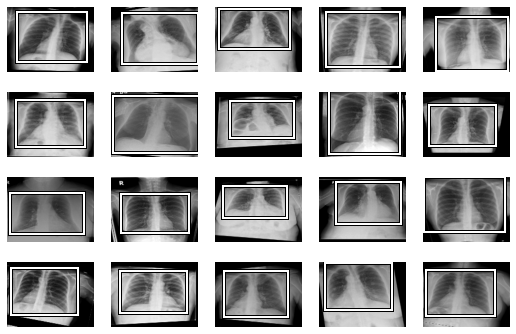

In [20]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

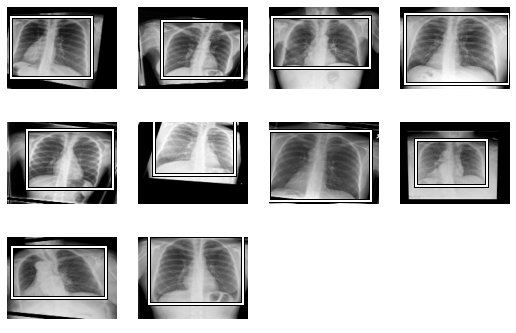

In [21]:
# Show a batch with less images than on the previous cell

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'show_batch')
# data.show_batch(10, figsize=(9,6)) 
# Instead of data.show_batch() it should be dls.show_batch() & the first argument must be max_n=10, not just 10 
dls.show_batch(max_n=10, figsize=(9,6)) 
# NOTE: figsize value is the same as on the previous cell but here the images are bigger, why? 
# I SUPPOSE figsize is the size of the window that contains all the images 

In [22]:
# Show the list of validation images

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'valid_ds')
# data.valid_ds.items
# Instead of data.valid_ds.items it should be dls.valid_ds.items 
dls.valid_ds.items

[Path('valid/72101428196582307502088862225697086951_h22qux.png'),
 Path('valid/7236320122922059402885847467572564402_ip6rt3.png'),
 Path('valid/72728473466202055347781620482410570194_8kh9je.png'),
 Path('valid/72871459487596471980910187801069770406_zp4xk2.png'),
 Path('valid/73345147477698556822032391045475472903_rn2v1i.png'),
 Path('valid/73926471130491531581562044300038867917_dm16wr.png'),
 Path('valid/74099935777609988048836492025574936822_7yvj1j.png'),
 Path('valid/74414002541799532611807822790332393850_n8ottm.png'),
 Path('valid/74576479405710985759203367628923301316_i9epl9.png'),
 Path('valid/74627296977089817365640285531326550278_8n91gl.png'),
 Path('valid/74633635885366415429936965588249219475_llod78.png'),
 Path('valid/7482022898066590109960377402792812378_jsk1xc.png'),
 Path('valid/75240060710771828959248521592001123841_o0tyt9.png'),
 Path('valid/75288701376420592992055266537258582029_taw0gf.png'),
 Path('valid/75314011958928212422271782369956360753_cp8vig.png'),
 Path('valid

In [23]:
# Get the data (PILImage, TensorBBox, TensorMultiCategory) of the first image of the validation dataset

# NOTE: why does batch variable encapsulates the type of data mentioned on the above line

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'valid_dl')
# batch = next(iter(data.valid_dl))
# Instead of data.valid_dl it should be dls.valid_ds
batch = next(iter(dls.valid_ds))

In [24]:
# Show the TensorBBox data of the batch variable created on the previous cell

# Next line from the original code is commented because it returns error ('PILImage' object is not subscriptable)
# batch[0][0][1]
# The output to the previous line shown on VICOROB's Github is: 
'''
tensor([[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        ...,
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
       device='cuda:0')
'''

# The closest output to the one of the original code is gotten by running the next line
batch[1]
# The output is: TensorBBox([[ 93.5000,  38.5000, 428.5000, 383.5000]])
# The function called is TensorBBox instead of tensor

# NOTE: Ask the professors why I can't get the same ouput as on the original code 
# What does the ouput of batch[0][0][1] from the original code represent?
# Why there is more than one inner list? On my ouput TensorBBox just has 1 list inside the outer list 

# And why the tensor has lists with at least 7 elements of the same value (-2.0357)?
# Shouldn't the lists have just 4 elements like on my output (the coordinates of the bbox)? 
# RESEARCH -> check if TensorBBox() is an upgrade of tensor(), do they do the same work?


TensorBBox([[ 90.0000, 156.5000, 472.0000, 453.5000]])

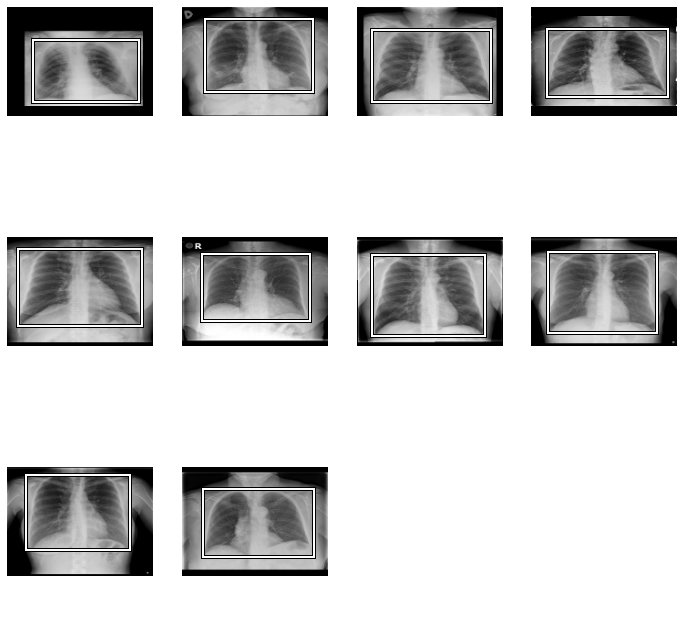

In [25]:
# Show a batch of validation images 

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'show_batch')
# data.show_batch(rows=10, ds_type=DatasetType.Valid, figsize=(12,12))
# I replaced the original line for the next one (it doesn't actually have the same behaviour because instead of rows=10 I use max_n=10,
# it's because the parameter rows is not longer part of the show_batch() method)

dls.valid.show_batch(max_n=10, figsize=(12,12))


## Train model
from https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb


In [26]:
# NOTE: what do the next functions of this cell relate? 
# NOTE: Why the next relations between predictions & targets are necessary?

def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:]) # NOTE: Why max_xy is the minimum between max_xy of preds & targs
    min_xy = torch.max(preds[:, :2], targs[:, :2]) # NOTE: Why min_xy is the maximum between min_xy of preds & targs
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes):
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs): 
    return intersection(preds, targs) / union(preds, targs)

In [27]:
# NOTE: Don't understand what this cell does 

SMOOTH = 1e-6 

def iou_rm(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # rm error not being byte 
    outputs = outputs > 0.5
    labels = labels.Byte()
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    
# Numpy version
# Well, it's the same function, so I'm going to omit the comments

def iou_np(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

In [28]:
# Create the Lung Detector model from a pre-trained model  

class LungDetector(nn.Module):
    def __init__(self, arch=models.resnet18): # resnet18 has 18 lineal layers and it's default arch if none arch is set as parameter
        super().__init__() 
        self.cnn = create_body(arch) # cut off the body of a typically pretrained arch
        self.head = create_head(num_features_model(self.cnn), 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [29]:
# NOTE: What is a loss function and why L1Loss() is returned?
# NOTE: explain what this cell does 

def loss_fn(preds, targs):
    return L1Loss()(preds, targs.squeeze())

In [30]:
# NOTE: What do these lines do. Explain it.


# Next line from the original code is commented because it produces the error: 
# 'DataBlock' object has no attribute 'train'; when executing the function learn.lr_find() on 3 cells next 
# learn = Learner(data, LungDetector(arch=models.resnet50), loss_func=loss_fn)
# I replace the previous line with the following one: (change data argument for dls)
learn = Learner(dls, LungDetector(arch=models.resnet50), loss_func=loss_fn)
# The error is solved because the attribute 'train' is on a DataLoaders object not on a DataBlock object


In [31]:
# NOTE: Whats does split function do? Explain what this cell does.

# Next line from the original code is commented because it returns error ('LungDetector' object has no attribute 'split')
# learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

# Instead of learn.split() the call that is acceptable as of this day (5/3/22) is learn._split()
learn._split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])


In [32]:
# NOTE: What do the next line does. Explain it.

# Freezes all the layers of the CNN except the last one
learn.freeze_to(-1)

SuggestedLRs(valley=0.010964781977236271)

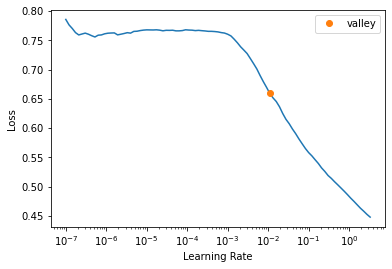

In [33]:
# Find a good learning rate with the learning rate finder

learn.lr_find()
# NOTE: when running the above line an error is returned: running_mean should contain 4096 elements not 8192
# What is running_mean and why it should have 4096 elements?
# ORIGINAL CODE 
# learn.recorder.plot_lr_find() # commented because lr_find() method already plots the loss-learning rate graphic

In [35]:
learn.metrics = [lambda preds, targs: IoU(preds, targs.squeeze()).mean()]

In [36]:
# Fit our model

# ORIGINAL CODE
# %time learn.fit_one_cycle(100, 1e-2, div_factor=12, pct_start=0.2) # find this function at schedule.py of callbacks dir (div_factor is obsolete)
# NOTE: I suppose div_factor has to be div (CHECK IT!)
# MODIFIED CODE
%time learn.fit_one_cycle(100, 1e-2, div=12, pct_start=0.2) # find this function at schedule.py of callbacks dir (div_factor is obsolete)
# NOTE: What does "%time" do?

epoch,train_loss,valid_loss,,time
0,0.389195,1.614299,0.000000,00:26
1,0.375546,1.682864,0.000000,00:24
2,0.328887,1.649136,0.005605,00:24
3,0.296887,0.979416,0.282683,00:24
4,0.266436,0.226614,0.575808,00:24
5,0.248116,1.261291,0.159757,00:24
6,0.223643,0.482525,0.449728,00:24
7,0.205824,0.963029,0.289636,00:24
8,0.192441,0.603337,0.021291,00:24
9,0.181250,0.995439,0.113194,00:24


Wall time: 40min 4s


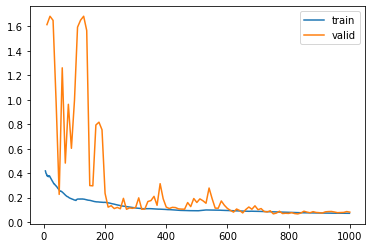

In [37]:
# Plot losses 

# ORIGINAL CODE
# learn.recorder.plot_losses() # commented because it returns error: AttributeError: 'LungDetector' object has no attribute 'plot_losses'

# Modified code
learn.recorder.plot_loss()

In [38]:
# NOTE: Explain what this cell does. Doubt: What does the output mean? 

# ORIGINAL CODE 
#data.train_ds # commented because it returns error: AttributeError: 'DataBlock' object has no attribute 'train_ds'

# Modified code
dls.train_ds

(#670) [(PILImage mode=RGB size=524x524, TensorBBox([[ 74.5000, 145.0000, 429.5000, 399.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 30.5000,  76.0000, 445.5000, 448.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 95.0000,  80.5000, 447.0000, 443.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 55.,  90., 435., 462.]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 21.,  73., 431., 485.]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 57.5000,  99.5000, 386.5000, 398.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 85.5000,  64.0000, 412.5000, 408.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 85.5000,  44.5000, 470.5000, 477.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 84.5000,  96.5000, 477.5000, 391.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 49.0000,  72.5000, 479.0000, 429.5000]]))...]

In [39]:
# NOTE: Explain what this cell does. Doubt: What does the output mean? 

# ORIGINAL CODE
#data.valid_ds # commented because it returns error: AttributeError: 'DataBlock' object has no attribute 'valid_ds'

dls.valid_ds

(#84) [(PILImage mode=RGB size=524x524, TensorBBox([[ 90.0000, 156.5000, 472.0000, 453.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 80.,  57., 470., 407.]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 55.0000, 108.5000, 483.0000, 455.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 54.5000, 103.5000, 489.5000, 432.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 39.0000,  57.5000, 485.0000, 424.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 71.0000,  81.5000, 461.0000, 400.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 53.5000,  83.0000, 460.5000, 475.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 57.5000,  70.0000, 450.5000, 460.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 67.5000,  35.0000, 440.5000, 397.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 73.0000, 102.5000, 475.0000, 429.5000]]))...]

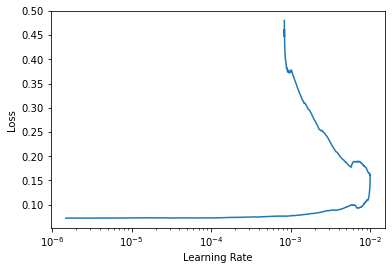

In [40]:
# Plot a Learning Rate - Loss graphic

# ORIGINAL CODE
# learn.recorder.plot_lr() # commented because it returns error: AttributeError: 'LungDetector' object has no attribute 'plot_lr'

# Modified code
learn.recorder.plot_lr_find() # it's not the same plot as learn.lr_find() because here the learning rate found is not shown 


In [41]:
# NOTE: Explain what this cell does.

learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

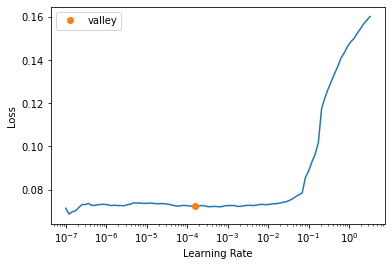

In [42]:
# Find a good learning rate with the learning rate finder after having unfreezed the model

learn.lr_find()

# ORIGINAL CODE 
# learn.recorder.plot_lr_find() # commented because lr_find() method already plots the loss-learning rate graphic

In [43]:
# NOTE: Explain what this cell does. 

# ORIGINAL CODE
# %time learn.fit_one_cycle(200, max_lr) # was 120 NOTE: What does the comment "was 120" refer to?

# Modified CODE
max_lr = 1e-2
%time learn.fit_one_cycle(200, max_lr) 

epoch,train_loss,valid_loss,,time
0,0.072128,0.091430,0.793070,00:23
1,0.072094,0.081807,0.811013,00:23
2,0.072616,0.076141,0.814688,00:23
3,0.072726,0.082856,0.801257,00:23
4,0.072326,0.086778,0.803541,00:23
5,0.072780,0.087111,0.798981,00:23
6,0.072722,0.086568,0.796221,00:23
7,0.073181,0.081970,0.797545,00:23
8,0.073404,0.064983,0.835983,00:23
9,0.073641,0.072397,0.814968,00:24


Wall time: 1h 20min 1s


In [44]:
# NOTE: Explain what this cell does. 

learn.save('lungs_detection_1ROI')

Path('models/lungs_detection_1ROI.pth')

In [45]:
# NOTE: Explain what this cell does. 

# doing this metrics [] because pickle in export does not accept lambda functions...
learn.metrics = []

# Use export function to save the Learner in dataset path/fname, using pickle_protocol. 
# Note that serialization in Python saves the names of functions, not the code itself. 
# Therefore, any custom code you have for models, data transformation, loss function etc... 
# should be put in a module that you will import in your training environment before exporting, 
# and in your deployment environment before loading it.
learn.export('trained_roi_detetor_resnet_export.pkl') # NOTE: what type of program can open a pkl file?

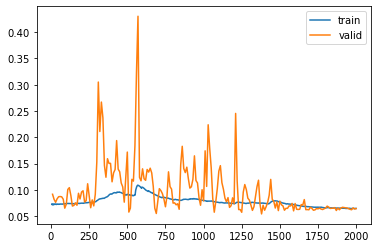

In [46]:
# Plot losses 

# ORIGINAL CODE
# learn.recorder.plot_losses() # commented because it returns error: AttributeError: 'LungDetector' object has no attribute 'plot_losses'

# Modified code
learn.recorder.plot_loss()

In [47]:
# NOTE: Explain what does this cell does.  

# ORIGINAL CODE
# learn.show_results() # commented because an error is returned: AssertionError: Match length mismatch
# Cause of error: https://forums.fast.ai/t/learn-show-results-results-in-assertion-error/77219/2 (See answer from "muellerzr")

# I have checked it's not possible for the moment to use show_results() on Object Detection with fastai v2 

## Inference

### Validation set

In [48]:
# NOTE: Explain what does this cell does.  

preds, targs = learn.get_preds() # NOTE: Why there are 83 preds and targs have 83 bboxes?
 
#predicted_bboxes = ((preds + 1) / 2 * img_size).numpy()
#targets = ((targs + 1) / 2 *  img_size).numpy().squeeze()
predicted_bboxes = ((preds + 1) / 2).numpy()
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray Example size: (83,4)

# targets = ((targs + 1) / 2).numpy().squeeze() # ORIGINAL CODE: TypeError: can only concatenate tuple (not "int") to tuple
targets = ((targs[0] + 1) / 2).numpy().squeeze()
# targs is a tuple of 2 elements, a TensorBBox (bboxes coordinates) and a TensorMultiCategory (bboxes labels)
# we have to normalize the bboxes coordinates, so we apply the normalization on targs[0]
# squeeze() makes targets size from (83,1,4) to (83,4)

# print(predicted_bboxes)
#print(targets)

def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
    sx,sy,ch = img.shape
#    print(sx,sy,ch)
    
    bbox[0] = bbox[0]*sx
    bbox[1] = bbox[1]*sy
    bbox[2] = bbox[2]*sx
    bbox[3] = bbox[3]*sy
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        target[0] = target[0]*sx
        target[1] = target[1]*sy
        target[2] = target[2]*sx
        target[3] = target[3]*sy
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

def cv_read(path): 
    path = str(path)
#    print(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
#    im = cv2.resize(im, (img_size,img_size))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(83)]) # ORIGINAL CODE
# previous line is commented because it returns error: AttributeError: 'DataBlock' object has no attribute 'valid_ds'
# It's replaced by the next line
ims = np.stack([draw_bbox(cv_read(dls.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(preds.shape[0])]) # store as many validation images as possible 

# Show some validation images with the predictions & targets of the bounding boxes (TARGETS ARE IN GREEN, PREDICTIONS IN RED)
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

IndexError: invalid index to scalar variable.

### Test set

In [ ]:
# Get test dataset
test_path = "Datasets/roi_detection_subset_originalRobert/test"
test_files = get_image_files(test_path)
# Create a test dataloader from test_items using validation transforms of dls
test_dl = learn.dls.test_dl(test_files) # Documentation: https://docs.fast.ai/data.core.html#DataLoaders.test_dl

preds, _ = learn.get_preds(dl=test_dl) # _ refers to the target bounding boxes which don't exist for the test set (there aren't annotation .txt files )
# is necessary to include _ to avoid the error "TypeError: can only concatenate tuple (not "int") to tuple" on predicted_bboxes creation
# preds is a TensorBase that contains lists of bboxes coordinates 
predicted_bboxes = ((preds+1)/2).numpy() # ACCURATE PREDICTIONS RESULTS 
#predicted_bboxes = preds.numpy() # BAD PREDICTION RESULTS 
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big? (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray Example size: (83,4)


# print(predicted_bboxes)
#print(targets)

def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
    sx,sy,ch = img.shape
#    print(sx,sy,ch)
    
    bbox[0] = bbox[0]*sx
    bbox[1] = bbox[1]*sy
    bbox[2] = bbox[2]*sx
    bbox[3] = bbox[3]*sy
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        target[0] = target[0]*sx
        target[1] = target[1]*sy
        target[2] = target[2]*sx
        target[3] = target[3]*sy
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

def cv_read(path): 
    path = str(path)
#    print(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
#    im = cv2.resize(im, (img_size,img_size))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(83)]) # ORIGINAL CODE
# previous line is commented because it returns error: AttributeError: 'DataBlock' object has no attribute 'valid_ds'
# It's replaced by the next line
ims = np.stack([draw_bbox(cv_read(dls.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(preds.shape[0])]) # store 83 validation images 

# Show some validation images with the predictions & targets of the bounding boxes (TARGETS ARE IN GREEN, PREDICTIONS IN RED)
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

TypeError: clip_remove_empty() missing 2 required positional arguments: 'bbox' and 'label'